In [1]:
# !pip uninstall zonepy -y
# !pip install git+https://github.com/vibe-lab-gsd/zonepy.git

In [2]:
# pip install pandas==2.1.4 geopandas==0.14.2

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import glob

from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import mapping

from joblib import Parallel, delayed
from tqdm import tqdm

# input my libraries
from zonepy import zp_get_crs
from zonepy import zp_find_district_idx
from zonepy import zp_read_dist
from zonepy import zp_read_pcl
from zonepy import zp_read_bldg
from zonepy import zp_get_dist_def
from zonepy import zp_get_parcel_dim
from zonepy import zp_get_parcel_geo
from zonepy import zp_get_unit_info
from zonepy import zp_get_variables
from zonepy import zp_get_zoning_req
from zonepy import zp_check_unit
from zonepy import zp_check_res_type
from zonepy import zp_check_constraints
from zonepy import zp_add_setbacks
from zonepy import zp_get_buildable_area
from zonepy import zp_check_fit
from zonepy import possible_checks
from zonepy import zp_run_zoning_checks

# Re-construct the Data

In [4]:
# tidyparcel_feeds = tidyparcel_geo_feeds.merge(tidyparcel_dim_feeds[['parcel_id','lot_width','lot_depth','lot_area','confidence']], on='parcel_id', how='left')

# mask = tidyparcel_feeds['side'] != 'centroid'
# tidyparcel_feeds.loc[mask, ['lot_width','lot_depth','lot_area','confidence']] = np.nan

# unqiue_id = tidyparcel_feeds[tidyparcel_feeds['confidence'] == 'non_confidence_parcel']['parcel_id'].unique()
# tidyparcel_feeds.loc[(tidyparcel_feeds['parcel_id'].isin(unqiue_id)) & (tidyparcel_feeds['side'] != 'centroid'), 'side'] = 'Unknown'

# tidyparcel_feeds[['Prop_ID','parcel_id','parcel_label','side','lot_width','lot_depth','lot_area','geometry']].to_crs("EPSG:4326").to_file(r"/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds.geojson", driver='GeoJSON')
# tidyparcel_feeds[tidyparcel_feeds['side'] == 'centroid'][['parcel_id','landuse','landuse_spec','confidence']].to_csv(r"/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds_land_use.csv", index=False)

In [5]:
# tidyparcel_feeds = gpd.read_file(r"/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds.geojson")
# tidyparcel_feeds

In [6]:
# # Example usage:
# process_all_districts(
#     tidyparcel_path="/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds.geojson",
#     district_folder="/Users/houpuli/Dropbox/ceshi/ozfs_without_overlay/",
#     output_folder="/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds/"
# )

# Step 1: some necessary functions
For the functions of this part, you don't have to run them, because all of them were intergrated into the later functions, I list them here just for your reference.

## `zp_get_crs` function
Kamryn uploaded a state plane reference to [guihub](https://raw.githubusercontent.com/KamrynMansfield/tidyzoning/main/inst/extdata/sp_crs.geojson), and this function will refer you to get the correct crs of the geojson file. And this function is used in the `zp_read_pcl` function.

In [7]:
Addison_district = gpd.read_file(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
print('The matched crs is EPSG:', zp_get_crs(Addison_district.loc[[0]]))

The matched crs is EPSG: 32138


# Step 2: Read files

## 01.`zp_read_dist` function
this function is for reading district info, and it will deleted those districts without valid geometry and re-index the structure, besides it will also auto-reproject the district data to the target crs by using "zp_get_crs" fucntion, while this function also allow you to input the target crs by yourself.

In [8]:
Addison_district = zp_read_dist(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning", trans_crs=3857)
print("current crs is", Addison_district.crs)
Addison_district.head(5)

current crs is EPSG:3857


,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry,zoning_id
0,Single-Family Dwelling,R-1,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.2...,"MULTIPOLYGON (((-10780184.101 3887684.743, -10...",0
3,Single-Family Dwelling,R-16,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.3...,"MULTIPOLYGON (((-10777090.621 3888246.808, -10...",3
4,Apartment Dwelling,A,False,False,"[2_unit, 3_unit, 4_plus, townhome]",{'lot_size': {'min_val': [{'expression': ['1']...,"MULTIPOLYGON (((-10778516.328 3891864.967, -10...",4
5,Local Retail,LR,False,False,NaN,NaN,"MULTIPOLYGON (((-10781846.642 3887084.891, -10...",5
6,Commercial-1,C-1,False,False,NaN,NaN,"MULTIPOLYGON (((-10778798.181 3888383.694, -10...",6


In [9]:
Addison_district = zp_read_dist(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning", trans_crs=None)
print("current crs is", Addison_district.crs)
Addison_district.head(5)

current crs is EPSG:32138


,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry,zoning_id
0,Single-Family Dwelling,R-1,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.2...,"MULTIPOLYGON (((755203.329 2142711.882, 755202...",0
3,Single-Family Dwelling,R-16,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.3...,"MULTIPOLYGON (((757793.793 2143223.087, 757790...",3
4,Apartment Dwelling,A,False,False,"[2_unit, 3_unit, 4_plus, townhome]",{'lot_size': {'min_val': [{'expression': ['1']...,"MULTIPOLYGON (((756548.273 2146227.618, 756547...",4
5,Local Retail,LR,False,False,NaN,NaN,"MULTIPOLYGON (((753814.918 2142188.501, 753814...",5
6,Commercial-1,C-1,False,False,NaN,NaN,"MULTIPOLYGON (((756357.973 2143314.560, 756354...",6


## 02.`zp_read_pcl` function
this funcion is for reading parcel info, and it will auto-match the same crs with the "district dataframe" created above(you cannot define the crs by yourself, because we must keep the same crs between "dist data" and "parcel_data", if you want to change the crs, you have define a crs by above "zp_read_dist" fucntion, and run "zp_read_pcl" fucntion again, and you will find the crs will change). Besides, this function will also add a "zoning_id" column to each parcel centroid row, which is the index of the district that contains the parcel centroid.

In [10]:
Addison_parcels = zp_read_pcl(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyparcel_feeds/Addison.parcel", Addison_district)
print("current crs is", Addison_parcels.crs)
Addison_parcels.head(5)

current crs is EPSG:32138


,parcel_id,side,lot_width,lot_depth,lot_area,geometry,zoning_id
0,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (753828.148 2141685.199, 753833.116...",NaN
1,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (753829.043 2141675.507, 753828.148...",NaN
2,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (754035.787 2141676.898, 754034.848...",NaN
3,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (754033.430 2141771.045, 754035.787...",NaN
4,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (754000.588 2141799.274, 754033.430...",NaN


#### `zp_get_parcel_dim` function
this funcion is for extracting all parcel dimension data("lot_width","lot_depth","lot_area") from original parcel data and correponding "parcel_id", besides, it will also split the parcel into two parts("corner" or "regular") by identidying whether "exterior side" exists or not.

In [11]:
zp_get_parcel_dim(Addison_parcels)

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,zoning_id
0,Dallas_County_combined_parcel_101985,1.000000,1.000000,3.029635,regular,no,centroid,POINT (753967.508 2141717.861),11
1,Dallas_County_combined_parcel_102535,119.814881,208.678146,0.573980,regular,yes,centroid,POINT (753782.051 2142205.528),"[5, 11]"
2,Dallas_County_combined_parcel_103676,1.000000,1.000000,9.071160,regular,no,centroid,POINT (754270.641 2142313.614),11
3,Dallas_County_combined_parcel_103690,1.000000,1.000000,4.768296,regular,no,centroid,POINT (754097.899 2141819.748),11
4,Dallas_County_combined_parcel_103695,1.000000,1.000000,3.969046,regular,no,centroid,POINT (754134.798 2141749.830),11
...,...,...,...,...,...,...,...,...,...
2634,Dallas_County_combined_parcel_81817,1.000000,1.000000,0.094835,regular,no,centroid,POINT (753801.562 2142827.307),14
2635,Dallas_County_combined_parcel_81818,1.000000,1.000000,0.102011,regular,no,centroid,POINT (753783.314 2142828.596),14
2636,Dallas_County_combined_parcel_81819,124.065756,401.645015,1.136832,regular,yes,centroid,POINT (753807.160 2142787.120),27
2637,Dallas_County_combined_parcel_81822,194.852130,391.729181,1.733046,corner,yes,centroid,POINT (754036.944 2142596.153),5


#### `zp_get_parcel_geo` function
this funcion is for extracting all confident parcel geometry without "centroid" points, which is useful for later "zp_get_buildable_area" function and "zp_check_fit"

In [12]:
zp_get_parcel_geo(Addison_parcels)

,parcel_id,side,geometry
0,Dallas_County_combined_parcel_102535,interior side,"LINESTRING (753814.050 2142187.387, 753750.347..."
1,Dallas_County_combined_parcel_102535,rear,"LINESTRING (753813.755 2142223.962, 753814.050..."
2,Dallas_County_combined_parcel_102535,interior side,"LINESTRING (753750.053 2142223.668, 753813.755..."
3,Dallas_County_combined_parcel_102535,front,"LINESTRING (753750.347 2142187.093, 753750.053..."
4,Dallas_County_combined_parcel_104000,interior side,"LINESTRING (753824.836 2142394.500, 753824.880..."
...,...,...,...
6500,Dallas_County_combined_parcel_81822,exterior side,"LINESTRING (754066.019 2142655.691, 754066.948..."
6501,Dallas_County_combined_parcel_81827,exterior side,"LINESTRING (753795.082 2142412.365, 753749.363..."
6502,Dallas_County_combined_parcel_81827,front,"LINESTRING (753749.363 2142412.121, 753749.279..."
6503,Dallas_County_combined_parcel_81827,interior side,"LINESTRING (753749.279 2142457.881, 753794.999..."


## 03.`zp_read_bldg` function
this function is for reading preliminary building info, transferring json file into dictionary format, which is useful for "get_variables_function" later.

In [13]:
zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")

{'bldg_info': {'height_top': 38,
  'height_plate': 37,
  'roof_type': 'flat',
  'width': 52,
  'depth': 48,
  'parking': 4,
  'sep_platting': False},
 'unit_info': [{'fl_area': 1108,
   'bedrooms': 3,
   'qty': 4,
   'entry_level': 1,
   'outside_entry': True}],
 'level_info': [{'level': 1, 'gross_fl_area': 1534},
  {'level': 2, 'gross_fl_area': 1533},
  {'level': 3, 'gross_fl_area': 1533}]}

## 04.`zp_get_dist_def` function
this funcion is for extracting definition from the "district data" by input dist path, including "height" and "res_type".

In [14]:
zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")

{'height': [{'condition': "roof_type == 'flat'", 'expression': 'height_top'},
  {'condition': "roof_type == 'hip'",
   'expression': '0.5 * (height_top + height_eave)'},
  {'condition': "roof_type == 'mansard'", 'expression': 'height_deck'},
  {'condition': "roof_type == 'gable'",
   'expression': '0.5 * (height_top + height_eave)'},
  {'condition': "roof_type == 'skillion'",
   'expression': '0.5 * (height_top + height_eave)'},
  {'condition': "roof_type == 'gambrel'",
   'expression': '0.5 * (height_top + height_eave)'}],
 'res_type': [{'condition': 'total_units == 1', 'expression': "'1_unit'"},
  {'condition': 'total_units == 2', 'expression': "'2_unit'"},
  {'condition': ['total_units > 2',
    'n_outside_entry == total_units',
    'n_ground_entry == total_units',
    'sep_platting == TRUE'],
   'expression': "'townhome'"},
  {'condition': 'total_units == 3', 'expression': "'3_unit'"},
  {'condition': 'total_units > 3', 'expression': "'4_plus'"}]}

# Functions

## `zp_get_variables` function
this function is for extracting and calculating building info by query data from dist info, and it will return a dataframe with all the variables you need, involving the "height" and "res_type" at the end of dataframe. The "bldg_data" and "zoning_data" can be input as dict or path, the "parcels_data" and "district_data" only can be geodataframe generated by`zp_read_pcl` and `zp_read_dist` functions.   
And this function will be intergrated into the `zp_get_zoning_req` function later.

In [15]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [16]:
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)
vars

,bldg_depth,bldg_width,dist_abbr,fl_area,fl_area_first,fl_area_top,stories,height_deck,height_eave,height_plate,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,lot_cov_bldg,unit_density,far,height,res_type
0,48,52,PDTC,4600,1534,1533,3,38,38,37,...,0.0,0.0,1.0,0.0,1108.0,1.863405,1.3008,0.034342,38,4_plus


In [17]:
vars = zp_get_variables(r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg',parcel_data, district_data, r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning')
vars

,bldg_depth,bldg_width,dist_abbr,fl_area,fl_area_first,fl_area_top,stories,height_deck,height_eave,height_plate,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,lot_cov_bldg,unit_density,far,height,res_type
0,48,52,PDTC,4600,1534,1533,3,38,38,37,...,0.0,0.0,1.0,0.0,1108.0,1.863405,1.3008,0.034342,38,4_plus


## `zp_get_zoning_req` function
this function is for calculating specific zoning requirements based on the provided extracting variables and district data. It returns a DataFrame containing the constraints for each district, including variables such as "setback", "lot_coverage", and "height"(not including "unit_size", we have another function `check_unit`for that).

In [18]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [19]:
district_data.iloc[0]['constraints']

{'lot_size': {'min_val': [{'expression': ['0.06 * total_units']}]},
 'setback_front': {'min_val': [{'expression': ['25']}]},
 'setback_side_int': {'min_val': [{'condition': ['floors <= 1',
     "res_type == '2_unit' or res_type == '3_unit'"],
    'expression': ['10']},
   {'condition': ['floors > 1',
     "res_type == '2_unit' or res_type == '3_unit'"],
    'min_max': 'max',
    'expression': ['15', '15']},
   {'condition': ['floors <= 1',
     "res_type == '4_plus' or res_type == 'townhome'"],
    'expression': ['10']},
   {'condition': ['floors > 1',
     "res_type == '4_plus' or res_type == 'townhome'"],
    'min_max': 'max',
    'expression': ['15', '15']}]},
 'setback_side_ext': {'min_val': [{'expression': ['25']}]},
 'setback_rear': {'min_val': [{'expression': ['25']}]},
 'lot_cov_bldg': {'max_val': [{'expression': ['50']}]},
 'parking_uncovered': {'min_val': [{'expression': ['2 * total_units']}]},
 'unit_size': {'min_val': [{'expression': ['750'],
    'condition': ["res_type == 

In [20]:
zoning_req = zp_get_zoning_req(district_data, bldg_data, parcel_data, dist_def)
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,lot_size,0.24,NaN,None,None
1,setback_front,25.0,NaN,None,None
2,setback_side_int,"(10.0, 15.0)",NaN,None,None
3,setback_side_ext,25.0,NaN,None,None
4,setback_rear,25.0,NaN,None,None
5,lot_cov_bldg,None,50.0,None,None
6,parking_uncovered,8.0,NaN,None,None
7,unit_density,None,18.0,None,None


In [21]:
zoning_req = zp_get_zoning_req(district_data, bldg_data=None, parcel_data=None, zoning_data=None, vars=vars)
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,lot_size,0.24,NaN,None,None
1,setback_front,25.0,NaN,None,None
2,setback_side_int,"(10.0, 15.0)",NaN,None,None
3,setback_side_ext,25.0,NaN,None,None
4,setback_rear,25.0,NaN,None,None
5,lot_cov_bldg,None,50.0,None,None
6,parking_uncovered,8.0,NaN,None,None
7,unit_density,None,18.0,None,None


## `zp_check_unit` function
this function is for extracting bedrooms and corresponding fl_area in each unit. And it will check whether the unit is fit for the zoning requirements, and return a DataFrame with the results.

In [22]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [23]:
zp_check_unit(district_data, bldg_data, vars)

True

## `zp_check_res_type` function
this function is for checking whether the building is allowed by district use_type?

In [24]:
zp_check_res_type(vars, district_data)

True

## `zp_check_constraints` function
this function is for checking whether the variables is allowed by zoning requirements.

In [25]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)
zoning_req = zp_get_zoning_req(district_data, bldg_data, parcel_data, dist_def)

In [26]:
vars

,bldg_depth,bldg_width,dist_abbr,fl_area,fl_area_first,fl_area_top,stories,height_deck,height_eave,height_plate,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,lot_cov_bldg,unit_density,far,height,res_type
0,48,52,PDTC,4600,1534,1533,3,38,38,37,...,0.0,0.0,1.0,0.0,1108.0,1.863405,1.3008,0.034342,38,4_plus


In [27]:
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,lot_size,0.24,NaN,None,None
1,setback_front,25.0,NaN,None,None
2,setback_side_int,"(10.0, 15.0)",NaN,None,None
3,setback_side_ext,25.0,NaN,None,None
4,setback_rear,25.0,NaN,None,None
5,lot_cov_bldg,None,50.0,None,None
6,parking_uncovered,8.0,NaN,None,None
7,unit_density,None,18.0,None,None


In [28]:
zp_check_constraints(vars, zoning_req, checks=None)

,constraint_name,allowed
0,lot_size,True
5,lot_cov_bldg,True
7,unit_density,True


## `zp_add_setbacks` function
assign setback info of each zoning req to the parcel geo data, which is useful for later "zp_get_buildable_area" function.

In [29]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
district_data = Addison_district[Addison_district['dist_name']=='Planned Development Townhouse/Condominium']
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id']=='Dallas_County_combined_parcel_48828']
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)
zoning_req = zp_get_zoning_req(district_data, bldg_data, parcel_data, dist_def)

parcel_geo = zp_get_parcel_geo(Addison_parcels)
parcel_geo_data = parcel_geo[parcel_geo['parcel_id'] == 'Dallas_County_combined_parcel_48828']

In [30]:
parcel_geo[parcel_geo['parcel_id'] == 'Dallas_County_combined_parcel_48828']

,parcel_id,side,geometry
792,Dallas_County_combined_parcel_48828,interior side,"LINESTRING (754756.696 2143794.120, 754758.081..."
793,Dallas_County_combined_parcel_48828,exterior side,"LINESTRING (754654.457 2143673.108, 754653.765..."
794,Dallas_County_combined_parcel_48828,rear,"LINESTRING (754652.826 2143793.634, 754756.696..."
795,Dallas_County_combined_parcel_48828,front,"LINESTRING (754758.081 2143673.352, 754754.912..."


In [31]:
parcels_with_setbacks = zp_add_setbacks(parcel_geo_data, district_data, zoning_req)
parcels_with_setbacks

,parcel_id,side,geometry,setback
792,Dallas_County_combined_parcel_48828,interior side,"LINESTRING (754756.696 2143794.120, 754758.081...","(10.0, 15.0)"
793,Dallas_County_combined_parcel_48828,exterior side,"LINESTRING (754654.457 2143673.108, 754653.765...",25.0
794,Dallas_County_combined_parcel_48828,rear,"LINESTRING (754652.826 2143793.634, 754756.696...",25.0
795,Dallas_County_combined_parcel_48828,front,"LINESTRING (754758.081 2143673.352, 754754.912...",25.0


## `zp_get_buildable_area` function
assign setback info of each zoning req to the parcel geo data, which is useful for later "zp_get_buildable_area" function.

In [32]:
buildable_area = zp_get_buildable_area(parcels_with_setbacks)
buildable_area

,parcel_id,buildable_geometry_relaxable,buildable_geometry_strict
0,Dallas_County_combined_parcel_48828,"POLYGON ((754660.7521952799 2143786.050875746,...","POLYGON ((754660.752 2143786.051, 754752.212 2..."


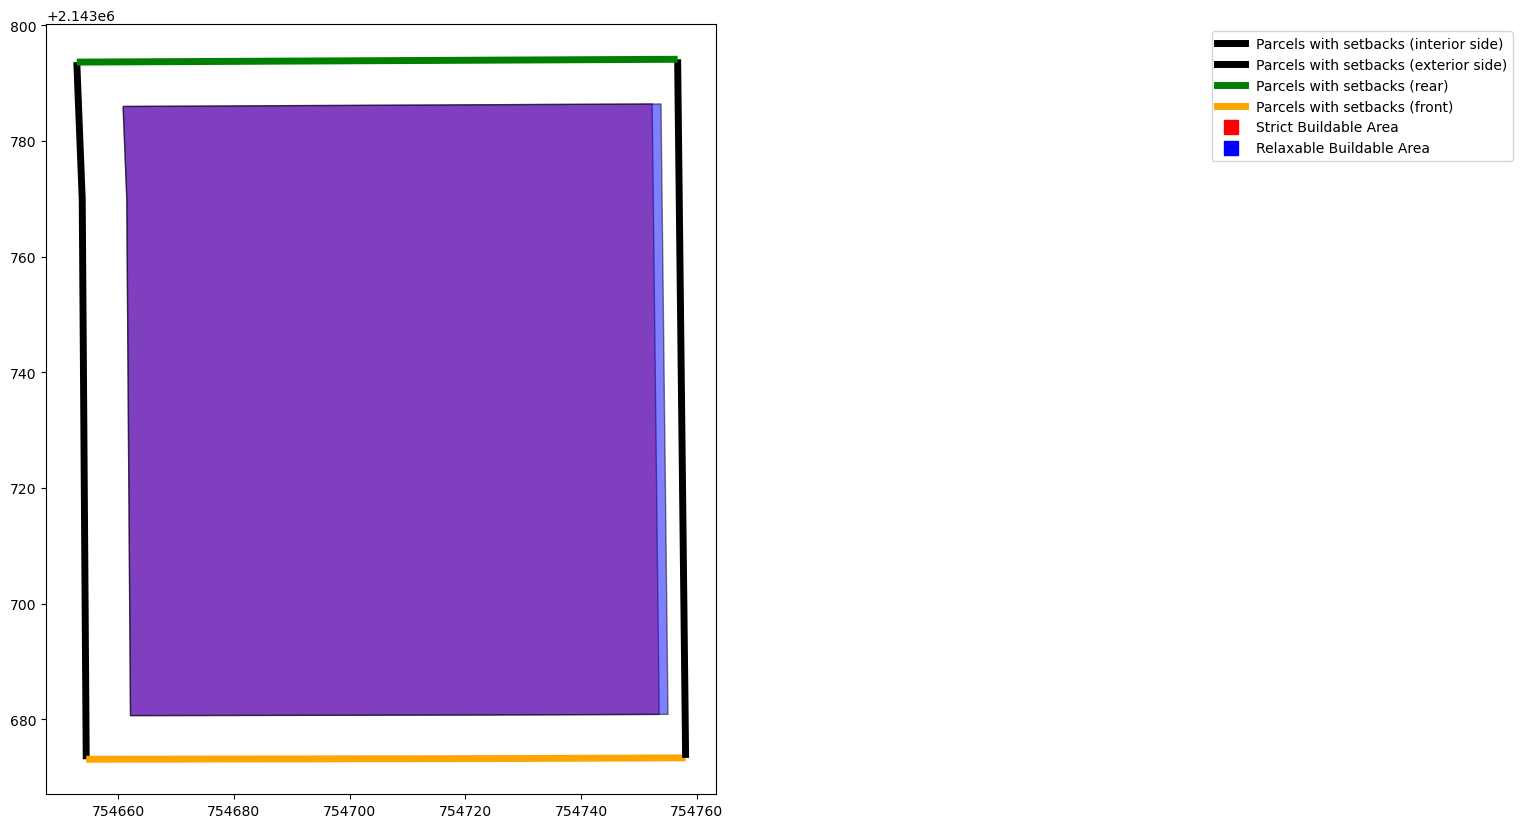

In [33]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Define a mapping from 'side' values to colors.
color_mapping = {
    'Interior side': 'red',
    'Exterior side': 'blue',
    'rear': 'green',
    'front': 'orange'
}

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the setbacks results by grouping based on the 'side' column.
for side, group in parcels_with_setbacks.groupby('side'):
    group.plot(
        ax=ax, 
        color=None, 
        alpha=1, 
        edgecolor=color_mapping.get(side, 'black'), 
        linewidth=5, 
        label=f'Parcels with setbacks ({side})'
    )

# Plot the strict buildable area.
strict_area = buildable_area.copy().set_geometry('buildable_geometry_strict')
strict_area.plot(
    ax=ax, 
    color='red', 
    alpha=0.5, 
    edgecolor='black', 
    label='Strict Buildable Area'
)

# Plot the relaxable buildable area.
relaxable_area = buildable_area.copy().set_geometry('buildable_geometry_relaxable')
relaxable_area.plot(
    ax=ax, 
    color='blue', 
    alpha=0.5, 
    edgecolor='black', 
    label='Relaxable Buildable Area'
)

# Create custom legend handles.
handles = []
# Add legend handles for each setbacks side.
for side in parcels_with_setbacks['side'].unique():
    color = color_mapping.get(side, 'black')
    handle = mlines.Line2D([], [], color=color, linewidth=5, label=f'Parcels with setbacks ({side})')
    handles.append(handle)
# Add handles for the buildable area layers.
handles.append(mlines.Line2D([], [], color='red', marker='s', markersize=10,
                             markerfacecolor='red', linestyle='None',
                             label='Strict Buildable Area'))
handles.append(mlines.Line2D([], [], color='blue', marker='s', markersize=10,
                             markerfacecolor='blue', linestyle='None',
                             label='Relaxable Buildable Area'))

ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(2.2, 1))
plt.show()

## `zp_check_fit` function
check whether the building footprint can fit into the parcel buildable_area.

In [34]:
zp_check_fit(buildable_area, vars)

,parcel_id,allowed
0,Dallas_County_combined_parcel_48828,True


## `zp_run_zoning_checks` function
check whether the building footprint can fit into the parcel buildable_area.

In [ ]:
zp_run_zoning_checks(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/2_fam.bldg", 
                     r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test',
                     r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test',
                     detailed_check=False,
                     checks=possible_checks,
                     )

# Debug Processing

In [ ]:
import time
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import mapping
import os
import json
import glob

# input my libraries
from zonepy import zp_get_crs
from zonepy import zp_find_district_idx
from zonepy import zp_read_dist
from zonepy import zp_read_pcl
from zonepy import zp_read_bldg
from zonepy import zp_get_dist_def
from zonepy import zp_get_parcel_dim
from zonepy import zp_get_parcel_geo
from zonepy import zp_get_unit_info
from zonepy import zp_get_variables
from zonepy import zp_get_zoning_req
from zonepy import zp_check_unit
from zonepy import zp_check_res_type
from zonepy import zp_check_constraints
from zonepy import zp_add_setbacks
from zonepy import zp_get_buildable_area
from zonepy import zp_check_fit
from zonepy import possible_checks


def zp_run_zoning_checks(
    bldg_file, 
    parcel_files, 
    zoning_files,
    detailed_check=False,
    print_checkpoints=True,
    checks=None,
    save_to=None
):
    """
    Python equivalent of zr_run_zoning_checks():
    Returns, for each parcel_id, whether building is allowed and the reason,
    with geometry set to the parcel centroid.

    Parameters are identical to the R version:
      bldg_file:   path to the .bldg file
      parcel_files: path to a .parcel file or a directory of such files
      zoning_files: path to a .zoning file or a directory of such files
      detailed_check: whether to retain all intermediate FALSE/MAYBE records
      print_checkpoints: whether to print timing information for each step
      checks:       list of checks to perform (default is possible_checks)
      save_to:      if not None, path to save the output GeoJSON
    """
    
    start_time = time.time()

    # ————————— 0. Parameter validation ————————— #
    # 1. Validate checks input parameter
    if checks is None:
        checks = possible_checks.copy()
    bad = [c for c in checks if c not in possible_checks]
    if bad:
        warnings.warn(f"Unknown constraints: {bad}")

    # 2. Determine initial constraints to run (excluding built-in res_type/unit_size/bldg_fit/overlay)
    initial_checks = [
        c for c in checks
        if c not in ("res_type", "unit_size", "bldg_fit", "overlay")
    ]

    # 3. Process zoning_files: support single file or directory
    if isinstance(zoning_files, str):
        if os.path.isdir(zoning_files):
            zoning_files = glob.glob(os.path.join(zoning_files, "*.zoning"))
        else:
            zoning_files = [zoning_files]

    # 4. Process parcel_files: same as above
    if isinstance(parcel_files, str):
        if os.path.isdir(parcel_files):
            parcel_files = glob.glob(os.path.join(parcel_files, "*.parcel"))
        else:
            parcel_files = [parcel_files]

    # ————————— 1. Data preparation ————————— #
    # 1. Read building JSON
    bldg_data = zp_read_bldg(bldg_file)

    # 2. Read zoning layers and corresponding JSON
    zoning_gdfs = []
    zoning_jsons = []

    first = True
    target_crs = None
    for muni_id, zf in enumerate(zoning_files):
        gz = zp_read_dist(zf)
        if first:
            target_crs = gz.crs
            first = False
        else:
            gz = gz.to_crs(target_crs)
        with open(zf, "r") as f:
            js = json.load(f)
        gz["muni_name"] = js.get("muni_name")  
        gz["muni_id"] = muni_id
        zoning_gdfs.append(gz)
        zoning_jsons.append(js)
    zoning_all = pd.concat(zoning_gdfs, ignore_index=True)
    
    # 3. Create unique zoning_id by combining muni_id and original zoning_id
    zoning_all['zoning_id'] = (zoning_all['muni_id'].astype(int).astype(str) + '_' + zoning_all['zoning_id'].astype(int).astype(str))
    
    # 4. Separate into overlays, planned_dev districts, and base zones
    overlays = zoning_all[zoning_all["overlay"]   == True]
    pd_districts = zoning_all[zoning_all["planned_dev"]== True]
    base_zones  = zoning_all[(zoning_all["overlay"]   == False) & (zoning_all["planned_dev"]== False)]

    # 5. Read parcels and assign base zoning IDs
    parcel_list = [ zp_read_pcl(p, base_zones) for p in parcel_files ]
    parcels_sf = pd.concat(parcel_list, ignore_index=True)
    # 6. Generate parcel_geo with 'side' labels
    parcel_geo  = zp_get_parcel_geo(parcels_sf)
    # 7. Generate parcel_dims with centroid and dimensions, rename zoning_id to muni_base_id
    parcel_dims = zp_get_parcel_dim(parcels_sf)
    parcel_dims = parcel_dims.rename(columns={"zoning_id":"muni_base_id"})
    
    # 8. Add muni_pd_id and muni_overlay_id
    pd_idx = zp_find_district_idx(parcel_dims, pd_districts).rename(columns={"zoning_id":"muni_pd_id"})
    ov_idx = zp_find_district_idx(parcel_dims, overlays).rename(columns={"zoning_id":"muni_overlay_id"})
    parcel_dims = parcel_dims.merge(pd_idx[["parcel_id","muni_pd_id"]], on='parcel_id', how="left")
    parcel_dims = parcel_dims.merge(ov_idx[["parcel_id","muni_overlay_id"]], on='parcel_id', how="left")

    # 9. Add dist_abbr and muni_name for all zone IDs
    dist_abbr_map = zoning_all.set_index("zoning_id")["dist_abbr"].to_dict()
    muni_name_map = zoning_all.set_index("zoning_id")["muni_name"].to_dict()
        
    def collect_all(ids, mapping):
        vals = []
        def handle_one(zid):
            if pd.isna(zid):
                return
            v = mapping.get(zid)
            if isinstance(v, (list, tuple)):
                vals.extend(v)
            elif v is not None:
                vals.append(v)
        for z_id in ids:
            if isinstance(z_id, (list, tuple)):
                for sub_id in z_id:
                    handle_one(sub_id)
            else:
                handle_one(z_id)
        seen = set()
        uniq = []
        for v in vals:
            if v not in seen:
                seen.add(v)
                uniq.append(v)
        return uniq

    parcel_dims["all_zone_ids"] = parcel_dims[[
        "muni_base_id","muni_pd_id","muni_overlay_id"
    ]].values.tolist()
    parcel_dims["dist_abbr"] = parcel_dims["all_zone_ids"].apply(lambda ids: collect_all(ids, dist_abbr_map))
    parcel_dims["muni_name"] = parcel_dims["all_zone_ids"].apply(lambda ids: collect_all(ids, muni_name_map)) 
    
    # 10. Initialize false_reasons and maybe_reasons columns
    parcel_dims["false_reasons"] = None
    parcel_dims["maybe_reasons"] = None
    false_dfs = []
    maybe_dfs = []
    
    if print_checkpoints:
        elapsed = time.time() - start_time
        print(f"___data_prep___ {elapsed:.1f}s\n")

    # ————————— 2. Planned Development check ————————— #
    t0 = time.time()
    if not pd_districts.empty:
        # Identify parcels in planned development districts via muni_pd_id
        pd_parcels = pd_idx["parcel_id"][pd_idx["muni_pd_id"].notna()]
        # Mark these parcels as FALSE and record the reason
        mask_pd = parcel_dims["parcel_id"].isin(pd_parcels)
        parcel_dims.loc[mask_pd, "false_reasons"] = (
            parcel_dims.loc[mask_pd, "false_reasons"]
            .fillna("") .apply(lambda s: "PD_dist" if s=="" else s+",PD_dist")
        )
        # Add intermediate variable check_pd for detailed_check logic
        parcel_dims["check_pd"] = ~mask_pd
        if not detailed_check:
            df0 = parcel_dims[ mask_pd ]
            false_dfs.append(df0)
            parcel_dims = parcel_dims[~mask_pd]
        if print_checkpoints:
            print(f"___planned_dev_check___ {time.time()-t0:.1f}s, kept {parcel_dims.shape[0]} parcels\n")
            
    # ————————— 3. District checks ————————— #
    t1 = time.time()
    # 1. Warn about parcels crossing multiple base zones
    mask_dist_cross = parcel_dims["muni_base_id"].apply(lambda x: isinstance(x, (list, tuple)) and len(x) > 1)
    crossing = parcel_dims.loc[mask_dist_cross, "parcel_id"]
    if not crossing.empty:
        # Append 'cross_base_district' to maybe_reasons
        parcel_dims.loc[mask_dist_cross, "maybe_reasons"] = (
            parcel_dims.loc[mask_dist_cross, "maybe_reasons"]
            .fillna("")  # None -> ""
            .apply(lambda s: "cross_base_district" if s == "" else s + ",cross_base_district")
        )
        # Record intermediate flag for detailed_check logic
        parcel_dims["check_cross_base"] = ~mask_dist_cross
    # 2. Warn about parcels not covered by any district
    mask_dist_cover = (parcel_dims["muni_base_id"].isna() & parcel_dims["muni_pd_id"].isna() & parcel_dims["muni_overlay_id"].isna())
    missing = parcel_dims.loc[mask_dist_cover, "parcel_id"]
    if not missing.empty:
        # Append 'no_district' to maybe_reasons
        parcel_dims.loc[mask_dist_cover, "maybe_reasons"] = (
            parcel_dims.loc[mask_dist_cover, "maybe_reasons"]
            .fillna("")  # None -> ""
            .apply(lambda s: "no_district" if s == "" else s + ",no_district")
        )
        # Add intermediate variable check_dist_cover for detailed_check logic
        parcel_dims["check_dist_cover"] = ~mask_dist_cover

    # Handle cross-base and no-district cases
    if not detailed_check:
        mask_dist = mask_dist_cross | mask_dist_cover
        df_dist = parcel_dims.loc[mask_dist]
        maybe_dfs.append(df_dist)
        parcel_dims = parcel_dims.loc[~mask_dist]
    if print_checkpoints:
        print(f"___cross_no_dist_check___ {time.time()-t1:.1f}s, kept {parcel_dims.shape[0]} parcels\n")
            
    # ————————— 4. Variables & requirements ————————— #
    t2 = time.time()
    vars_map = {}
    req_map  = {}
    no_setback = set()

    def safe_sum(x):
        """
        Safely sum a value that may be None, NaN, or a list/tuple containing None/NaN.
        - None or NaN are treated as 0.
        - Lists/tuples are filtered of None/NaN before summing.
        """
        # Treat None or NaN as 0
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return 0
        # If list or tuple, filter out None/NaN and sum
        if isinstance(x, (list, tuple)):
            return sum(i for i in x if i is not None and not (isinstance(i, float) and np.isnan(i)))
        # Otherwise, return the numeric value directly
        return x

    for idx in parcel_dims.index:
        # Extract a one-row DataFrame (keeps column types) instead of a Series
        parcel_data = parcel_dims.loc[[idx]]
        pid = parcel_data.at[idx, "parcel_id"]
        # Build list of zoning IDs (may be a single ID or a list)
        ids = (parcel_data.at[idx, "muni_base_id"]
            if isinstance(parcel_data.at[idx, "muni_base_id"], (list, tuple))
            else [parcel_data.at[idx, "muni_base_id"]])
        # Subset zoning_all by those IDs
        dist_df = zoning_all[zoning_all["zoning_id"].isin(ids)]
        # Skip if there isn’t exactly one matching district
        if dist_df.shape[0] != 1:
            continue
        # Load that municipality’s JSON definitions
        muni_id = int(dist_df.iloc[0]["muni_id"])
        munijson = zoning_jsons[muni_id]["definitions"]
        # Compute variables and zoning requirements
        v = zp_get_variables(bldg_data, parcel_data, dist_df, munijson)
        z = zp_get_zoning_req(dist_df, bldg_data=None, parcel_data=None, zoning_data=None, vars=v)
        vars_map[pid] = v
        req_map[pid]  = z
        # Identify parcels with no setback requirements
        if isinstance(z, str):
            # If z is an error string, treat as no setbacks
            no_setback.add(pid)
        else:
            # Filter constraints containing “setback”
            sb = z[z["constraint_name"].str.contains("setback")]["min_value"]
            # If all are NaN or their safe sum is zero, mark as no setback
            if sb.isnull().all() or sb.apply(safe_sum).sum() == 0:
                no_setback.add(pid)
    print(f"___get_zoning_req___ {time.time()-t2:.1f}s\n")

    # ————————— 5. Initial checks (res_type, constraints, unit_size) ————————— #
    t3 = time.time()
    init_results = {}
    for idx in parcel_dims.index:
        parcel_data = parcel_dims.loc[[idx]]
        pid = parcel_data.at[idx, "parcel_id"]
        ids = (parcel_data.at[idx, "muni_base_id"]
            if isinstance(parcel_data.at[idx, "muni_base_id"], (list, tuple))
            else [parcel_data.at[idx, "muni_base_id"]])
        dist_df = zoning_all[zoning_all["zoning_id"].isin(ids)]
        if dist_df.empty:
            continue
        v   = vars_map[pid]
        z   = req_map[pid]

        # 1) Residential type check
        if "res_type" in checks:
            rt_ok = zp_check_res_type(v, dist_df)
            df_rt = pd.DataFrame({"res_type":[rt_ok]})
        else:
            df_rt = pd.DataFrame()

        # 2) Other quantitative constraints
        try:
            df_cons = zp_check_constraints(v, z, checks=initial_checks)
        except:
            df_cons = pd.DataFrame()
        if not df_cons.empty:
            df_c = df_cons.set_index("constraint_name")["allowed"].to_frame().T
        else:
            df_c = pd.DataFrame()

        # 3) Unit size check
        if "unit_size" in checks:
            u_ok = zp_check_unit(dist_df, bldg_data, v)
            df_u = pd.DataFrame({"unit_size":[u_ok]})
        else:
            df_u = pd.DataFrame()

        # Combine results into one DataFrame
        merged = pd.concat([df_rt, df_c.reset_index(drop=True), df_u], axis=1)
        merged.index = [idx]
        init_results[idx] = merged

        # Record reasons for FALSE/MAYBE
        vals = merged.iloc[0].astype(str)
        fals = vals[vals=="False"].index.tolist()
        mays = vals[vals=="MAYBE"].index.tolist()
        if fals:
            s = parcel_dims.at[idx,"false_reasons"] or ""
            parcel_dims.at[idx,"false_reasons"] = (",".join(fals) if s=="" else s + "," + ",".join(fals))
        if mays:
            s = parcel_dims.at[idx,"maybe_reasons"] or ""
            parcel_dims.at[idx,"maybe_reasons"] = (",".join(mays)if s=="" else s + "," + ",".join(mays))

        # If FALSE and not detailed_check, remove parcel to false_dfs
        if ("False" in vals.values) and (not detailed_check):
            false_dfs.append(parcel_dims.loc[[idx]])
            parcel_dims.drop(idx, inplace=True)

    # Concatenate all individual results into one DataFrame, preserving original idx as index
    init_df = pd.concat(init_results, axis=0)
    # init_df now has a two-level index; drop the first level (original idx)
    init_df.index = init_df.index.droplevel(0)
    # Treat NA as True (matching R behavior)
    init_df = init_df.fillna(True)
    # Join init_df back to parcel_dims aligned by index
    parcel_dims = parcel_dims.join(init_df)
    if print_checkpoints:
        print(f"___initial_checks___ {time.time()-t3:.1f}s\n")

    # ————————— 6. Side label check ————————— #
    if "bldg_fit" in checks and not parcel_dims.empty:
        t4 = time.time()
        known = set(parcel_geo.loc[parcel_geo["side"]!="unknown","parcel_id"])
        keep = known.union(no_setback)
        # Mark parcel_side_lbl flag
        parcel_dims["parcel_side_lbl"] = parcel_dims["parcel_id"].isin(keep)
        # Parcels without side label get MAYBE reason
        mask = ~parcel_dims["parcel_side_lbl"]
        parcel_dims.loc[mask, "maybe_reasons"] = (
            parcel_dims.loc[mask, "maybe_reasons"]
            .fillna("") .apply(lambda s: "side_lbl" if s=="" else s+",side_lbl")
        )
        # If not detailed_check, remove them to false_dfs
        if not detailed_check:
            false_dfs.append(parcel_dims[mask])
            parcel_dims = parcel_dims[~mask]
        if print_checkpoints:
            print(f"___side_label_check___ {time.time()-t4:.1f}s\n")

    # ————————— 7. Building fit check ————————— #
    parcel_dims["bldg_fit"] = None
    parcel_dims["bldg_fit"] = parcel_dims["bldg_fit"].astype(object)

    if "bldg_fit" in checks and not parcel_dims.empty:
        t5 = time.time()
        for idx in parcel_dims.index:
            if not parcel_dims.at[idx, "parcel_side_lbl"]:
                continue
            pid = parcel_dims.at[idx, "parcel_id"]
            sides = parcel_geo[parcel_geo["parcel_id"] == pid]
            if sides.empty:
                continue
            base_ids = parcel_dims.at[idx, "muni_base_id"]
            if not isinstance(base_ids, (list, tuple)):
                base_ids = [base_ids]
            dist_df = zoning_all[zoning_all["zoning_id"].isin(base_ids)]
            if dist_df.empty:
                continue
            v   = vars_map[pid]
            z   = req_map[pid]
            pg_sb = zp_add_setbacks(sides, dist_df, z)
            bz    = zp_get_buildable_area(pg_sb)
            fitdf = zp_check_fit(bz, v)
            ok = fitdf.loc[0,"allowed"]
            parcel_dims.at[idx,"bldg_fit"] = ok
            if ok=="MAYBE":
                s = parcel_dims.at[idx,"maybe_reasons"] or ""
                parcel_dims.at[idx,"maybe_reasons"] = "bldg_fit" if s=="" else s+",bldg_fit"
            if ok==False:
                s = parcel_dims.at[idx,"false_reasons"] or ""
                parcel_dims.at[idx,"false_reasons"] = "bldg_fit" if s=="" else s+",bldg_fit"
        if not detailed_check:
            mask = parcel_dims["bldg_fit"]==False
            false_dfs.append(parcel_dims[mask])
            parcel_dims = parcel_dims[~mask]
        if print_checkpoints:
            print(f"___bldg_fit___ {time.time()-t5:.1f}s\n")

    # ————————— 8. Overlay check ————————— #
    if "overlay" in checks and not overlays.empty:
        t6 = time.time()
        o_parcels = set(overlays["parcel_id"])
        mask = parcel_dims["parcel_id"].isin(o_parcels)
        parcel_dims.loc[mask, "maybe_reasons"] = (
            parcel_dims.loc[mask, "maybe_reasons"]
            .fillna("") .apply(lambda s: "overlay" if s=="" else s+",overlay")
        )
        if print_checkpoints:
            print(f"___overlay_check___ {time.time()-t6:.1f}s\n")

    # ————————— 9. Merge & output ————————— #
    # Concatenate all parcels removed to false_dfs plus those still in parcel_dims
    final = pd.concat(false_dfs + [parcel_dims], ignore_index=True)
    
    # Compute allowed & reason columns
    def summarize(r):
        fr = r.get("false_reasons") or ""
        mr = r.get("maybe_reasons") or ""
        if fr: return (False, fr)
        if mr: return ("MAYBE", mr)
        return (True, "Building allowed")

    final[["allowed","reason"]] = pd.DataFrame(
        final.apply(summarize, axis=1).tolist(),
        index=final.index
    )

    # Select output columns based on detailed_check
    if not detailed_check:
        out = final[[
            "parcel_id","muni_name","dist_abbr","allowed","reason","geometry"
        ]].copy()
    else:
        drop_cols = [
            "false_reasons","maybe_reasons",
            "lot_width","lot_depth","lot_area","lot_type",
            "zoning_id","pd_id","overlay_id"
        ]
        keep = [c for c in final.columns if c not in drop_cols]
        out = final[keep].copy()

    # Handle duplicate parcel_id cases (overlapping zones)
    dups = out["parcel_id"][out["parcel_id"].duplicated()].unique()
    if len(dups)>0:
        merged = []
        for pid in dups:
            sub = out[out["parcel_id"]==pid]
            vals = sub["allowed"].tolist()
            if all(v==True for v in vals):
                v = True
            elif all(v==False for v in vals):
                v = False
            else:
                v = "MAYBE"
            reasons = " ---||--- ".join(sub["reason"].tolist())
            row = sub.iloc[0].copy()
            row["allowed"] = v
            row["reason"]  = reasons
            merged.append(row)
        out = out[~out["parcel_id"].isin(dups)].append(merged, ignore_index=True)

    # Save to GeoJSON if requested
    if save_to:
        dirname = os.path.dirname(save_to) or "."
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        out.to_file(save_to, driver="GeoJSON")
        if print_checkpoints:
            print(f"output saved to {save_to}")

    if print_checkpoints:
        total = time.time() - start_time
        ct_true = (out["allowed"]==True).sum()
        ct_may  = (out["allowed"]=="MAYBE").sum()
        print(f"_____summary_____")
        print(f"total runtime: {total:.1f}s")
        print(f"{ct_true}/{len(out)} parcels allow the building; {ct_may}/{len(out)} maybe allow")

    return gpd.GeoDataFrame(out, geometry="geometry", crs=parcels_sf.crs)


In [2]:
import time
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import mapping
import os
import json
import glob

# input my libraries
from zonepy import zp_get_crs
from zonepy import zp_find_district_idx
from zonepy import zp_read_dist
from zonepy import zp_read_pcl
from zonepy import zp_read_bldg
from zonepy import zp_get_dist_def
from zonepy import zp_get_parcel_dim
from zonepy import zp_get_parcel_geo
from zonepy import zp_get_unit_info
from zonepy import zp_get_variables
from zonepy import zp_get_zoning_req
from zonepy import zp_check_unit
from zonepy import zp_check_res_type
from zonepy import zp_check_constraints
from zonepy import zp_add_setbacks
from zonepy import zp_get_buildable_area
from zonepy import zp_check_fit
from zonepy import possible_checks

In [3]:
bldg_file = r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/2_fam.bldg"
zoning_files = r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test"
parcel_files = r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/test"

start_time = time.time()

# ————————— 0. Parameter validation ————————— #
# 1. Validate checks input parameter
checks = possible_checks.copy()

# 2. Determine initial constraints to run (excluding built-in res_type/unit_size/bldg_fit/overlay)
initial_checks = [
    c for c in checks
    if c not in ("res_type", "unit_size", "bldg_fit", "overlay")
]

# 3. Process zoning_files: support single file or directory
if isinstance(zoning_files, str):
    if os.path.isdir(zoning_files):
        zoning_files = glob.glob(os.path.join(zoning_files, "*.zoning"))
    else:
        zoning_files = [zoning_files]

# 4. Process parcel_files: same as above
if isinstance(parcel_files, str):
    if os.path.isdir(parcel_files):
        parcel_files = glob.glob(os.path.join(parcel_files, "*.parcel"))
    else:
        parcel_files = [parcel_files]
        

# ————————— 1. Data preparation ————————— #
# 1. Read building JSON
bldg_data = zp_read_bldg(bldg_file)

# 2. Read zoning layers and corresponding JSON
zoning_gdfs = []
zoning_jsons = []

first = True
target_crs = None
for muni_id, zf in enumerate(zoning_files):
    gz = zp_read_dist(zf)
    if first:
        target_crs = gz.crs
        first = False
    else:
        gz = gz.to_crs(target_crs)
    with open(zf, "r") as f:
        js = json.load(f)
    gz["muni_name"] = js.get("muni_name")  
    gz["muni_id"] = muni_id
    zoning_gdfs.append(gz)
    zoning_jsons.append(js)
zoning_all = pd.concat(zoning_gdfs, ignore_index=True)
zoning_all
# 3. Create unique zoning_id by combining muni_id and original zoning_id
zoning_all['zoning_id'] = (zoning_all['muni_id'].astype(int).astype(str) + '_' + zoning_all['zoning_id'].astype(int).astype(str))

# 4. Separate into overlays, planned_dev districts, and base zones
overlays = zoning_all[zoning_all["overlay"] == True]
pd_districts = zoning_all[zoning_all["planned_dev"] == True]
base_zones  = zoning_all[(zoning_all["overlay"] == False) & (zoning_all["planned_dev"]== False)]

# 5. Read parcels and assign base zoning IDs
parcel_list = [ zp_read_pcl(p, base_zones) for p in parcel_files ]
parcels_sf = pd.concat(parcel_list, ignore_index=True)
# 6. Generate parcel_geo with 'side' labels
parcel_geo  = zp_get_parcel_geo(parcels_sf)
# 7. Generate parcel_dims with centroid and dimensions, rename zoning_id to muni_base_id
parcel_dims = zp_get_parcel_dim(parcels_sf)
parcel_dims = parcel_dims.rename(columns={"zoning_id":"muni_base_id"})

# 8. Add muni_pd_id and muni_overlay_id
pd_idx = zp_find_district_idx(parcel_dims, pd_districts).rename(columns={"zoning_id":"muni_pd_id"})
ov_idx = zp_find_district_idx(parcel_dims, overlays).rename(columns={"zoning_id":"muni_overlay_id"})
parcel_dims = parcel_dims.merge(pd_idx[["parcel_id","muni_pd_id"]], on='parcel_id', how="left")
parcel_dims = parcel_dims.merge(ov_idx[["parcel_id","muni_overlay_id"]], on='parcel_id', how="left")

# 9. Add dist_abbr and muni_name for all zone IDs
dist_abbr_map = zoning_all.set_index("zoning_id")["dist_abbr"].to_dict()
muni_name_map = zoning_all.set_index("zoning_id")["muni_name"].to_dict()
def collect_all(ids, mapping):
    vals = []

    def handle_one(zid):
        if pd.isna(zid):
            return
        v = mapping.get(zid)
        if isinstance(v, (list, tuple)):
            vals.extend(v)
        elif v is not None:
            vals.append(v)

    for z_id in ids:
        if isinstance(z_id, (list, tuple)):
            for sub_id in z_id:
                handle_one(sub_id)
        else:
            handle_one(z_id)

    seen = set()
    uniq = []
    for v in vals:
        if v not in seen:
            seen.add(v)
            uniq.append(v)
    return uniq

parcel_dims["all_zone_ids"] = parcel_dims[[
    "muni_base_id","muni_pd_id","muni_overlay_id"
]].values.tolist()

parcel_dims["dist_abbr"] = parcel_dims["all_zone_ids"].apply(lambda ids: collect_all(ids, dist_abbr_map))
parcel_dims["muni_name"] = parcel_dims["all_zone_ids"].apply(lambda ids: collect_all(ids, muni_name_map))

# 10. Initialize false_reasons and maybe_reasons columns
parcel_dims["false_reasons"] = None
parcel_dims["maybe_reasons"] = None
false_dfs = []
maybe_dfs = []

elapsed = time.time() - start_time
print(f"___data_prep___ {elapsed:.1f}s\n")

detailed_check = False

# ————————— 2. Planned Development check ————————— #
t0 = time.time()
if not pd_districts.empty:
    # Identify parcels in planned development districts via muni_pd_id
    pd_parcels = pd_idx["parcel_id"][pd_idx["muni_pd_id"].notna()]
    # Mark these parcels as FALSE and record the reason
    mask_pd = parcel_dims["parcel_id"].isin(pd_parcels)
    parcel_dims.loc[mask_pd, "false_reasons"] = (
        parcel_dims.loc[mask_pd, "false_reasons"]
        .fillna("") .apply(lambda s: "PD_dist" if s=="" else s+",PD_dist")
    )
    # Add intermediate variable check_pd for detailed_check logic
    parcel_dims["check_pd"] = ~mask_pd
    
if not detailed_check:
    df0 = parcel_dims[ mask_pd ]
    false_dfs.append(df0)
    parcel_dims = parcel_dims[~mask_pd]

print(f"___planned_dev_check___ {time.time()-t0:.1f}s, kept {parcel_dims.shape[0]} parcels\n")

___data_prep___ 104.0s

___planned_dev_check___ 0.1s, kept 310149 parcels



In [4]:
# ————————— 3. District checks ————————— #
t1 = time.time()
# 1. Warn about parcels crossing multiple base zones
mask_dist_cross = parcel_dims["muni_base_id"].apply(lambda x: isinstance(x, (list, tuple)) and len(x) > 1)
crossing = parcel_dims.loc[mask_dist_cross, "parcel_id"]
if not crossing.empty:
    # Append 'cross_base_district' to maybe_reasons
    parcel_dims.loc[mask_dist_cross, "maybe_reasons"] = (
        parcel_dims.loc[mask_dist_cross, "maybe_reasons"]
        .fillna("")  # None -> ""
        .apply(lambda s: "cross_base_district" if s == "" else s + ",cross_base_district")
    )
    # Record intermediate flag for detailed_check logic
    parcel_dims["check_cross_base"] = ~mask_dist_cross
# 2. Warn about parcels not covered by any district
mask_dist_cover = (parcel_dims["muni_base_id"].isna() & parcel_dims["muni_pd_id"].isna() & parcel_dims["muni_overlay_id"].isna())
missing = parcel_dims.loc[mask_dist_cover, "parcel_id"]
if not missing.empty:
    # Append 'no_district' to maybe_reasons
    parcel_dims.loc[mask_dist_cover, "maybe_reasons"] = (
        parcel_dims.loc[mask_dist_cover, "maybe_reasons"]
        .fillna("")  # None -> ""
        .apply(lambda s: "no_district" if s == "" else s + ",no_district")
    )
    # Add intermediate variable check_dist_cover for detailed_check logic
    parcel_dims["check_dist_cover"] = ~mask_dist_cover

# Handle cross-base and no-district cases
if not detailed_check:
    mask_dist = mask_dist_cross | mask_dist_cover
    df_dist = parcel_dims.loc[mask_dist]
    maybe_dfs.append(df_dist)
    parcel_dims = parcel_dims.loc[~mask_dist]

print(f"___dist_cross_cover_check___ {time.time()-t1:.1f}s, kept {parcel_dims.shape[0]} parcels\n")

___dist_cross_cover_check___ 0.1s, kept 310110 parcels



In [5]:
# ————————— 4. Variables & requirements ————————— #
t2 = time.time()
vars_map = {}
req_map  = {}
no_setback = set()

def safe_sum(x):
    """
    Safely sum a value that may be None, NaN, or a list/tuple containing None/NaN.
    - None or NaN are treated as 0.
    - Lists/tuples are filtered of None/NaN before summing.
    """
    # Treat None or NaN as 0
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return 0
    # If list or tuple, filter out None/NaN and sum
    if isinstance(x, (list, tuple)):
        return sum(i for i in x if i is not None and not (isinstance(i, float) and np.isnan(i)))
    # Otherwise, return the numeric value directly
    return x

for idx in parcel_dims.index:
    # Extract a one-row DataFrame (keeps column types) instead of a Series
    parcel_data = parcel_dims.loc[[idx]]
    pid = parcel_data.at[idx, "parcel_id"]
    # Build list of zoning IDs (may be a single ID or a list)
    ids = (parcel_data.at[idx, "muni_base_id"]
        if isinstance(parcel_data.at[idx, "muni_base_id"], (list, tuple))
        else [parcel_data.at[idx, "muni_base_id"]])
    # Subset zoning_all by those IDs
    dist_df = zoning_all[zoning_all["zoning_id"].isin(ids)]
    # Skip if there isn’t exactly one matching district
    if dist_df.shape[0] != 1:
        continue
    # Load that municipality’s JSON definitions
    muni_id = int(dist_df.iloc[0]["muni_id"])
    munijson = zoning_jsons[muni_id]["definitions"]
    # Compute variables and zoning requirements
    v = zp_get_variables(bldg_data, parcel_data, dist_df, munijson)
    z = zp_get_zoning_req(dist_df, bldg_data=None, parcel_data=None, zoning_data=None, vars=v)
    vars_map[pid] = v
    req_map[pid]  = z
    # Identify parcels with no setback requirements
    if isinstance(z, str):
        # If z is an error string, treat as no setbacks
        no_setback.add(pid)
    else:
        # Filter constraints containing “setback”
        sb = z[z["constraint_name"].str.contains("setback")]["min_value"]
        # If all are NaN or their safe sum is zero, mark as no setback
        if sb.isnull().all() or sb.apply(safe_sum).sum() == 0:
            no_setback.add(pid)
print(f"___get_zoning_req___ {time.time()-t2:.1f}s\n")

___get_zoning_req___ 828.5s



In [6]:

# ————————— 5. Initial checks (res_type, constraints, unit_size) ————————— #
t3 = time.time()
init_results = {}
for idx in parcel_dims.index:
    parcel_data = parcel_dims.loc[[idx]]
    pid = parcel_data.at[idx, "parcel_id"]
    ids = (parcel_data.at[idx, "muni_base_id"]
        if isinstance(parcel_data.at[idx, "muni_base_id"], (list, tuple))
        else [parcel_data.at[idx, "muni_base_id"]])
    dist_df = zoning_all[zoning_all["zoning_id"].isin(ids)]
    if dist_df.empty:
        continue
    v   = vars_map[pid]
    z   = req_map[pid]

    # 1) Residential type check
    if "res_type" in checks:
        rt_ok = zp_check_res_type(v, dist_df)
        df_rt = pd.DataFrame({"res_type":[rt_ok]})
    else:
        df_rt = pd.DataFrame()

    # 2) Other quantitative constraints
    try:
        df_cons = zp_check_constraints(v, z, checks=initial_checks)
    except:
        df_cons = pd.DataFrame()
    if not df_cons.empty:
        df_c = df_cons.set_index("constraint_name")["allowed"].to_frame().T
    else:
        df_c = pd.DataFrame()

    # 3) Unit size check
    if "unit_size" in checks:
        u_ok = zp_check_unit(dist_df, bldg_data, v)
        df_u = pd.DataFrame({"unit_size":[u_ok]})
    else:
        df_u = pd.DataFrame()

    # Combine results into one DataFrame
    merged = pd.concat([df_rt, df_c.reset_index(drop=True), df_u], axis=1)
    merged.index = [idx]
    init_results[idx] = merged

    # Record reasons for FALSE/MAYBE
    vals = merged.iloc[0].astype(str)
    fals = vals[vals=="False"].index.tolist()
    mays = vals[vals=="MAYBE"].index.tolist()
    if fals:
        s = parcel_dims.at[idx,"false_reasons"] or ""
        parcel_dims.at[idx,"false_reasons"] = (",".join(fals) if s=="" else s + "," + ",".join(fals))
    if mays:
        s = parcel_dims.at[idx,"maybe_reasons"] or ""
        parcel_dims.at[idx,"maybe_reasons"] = (",".join(mays)if s=="" else s + "," + ",".join(mays))

    # If FALSE and not detailed_check, remove parcel to false_dfs
    if ("False" in vals.values) and (not detailed_check):
        false_dfs.append(parcel_dims.loc[[idx]])
        parcel_dims.drop(idx, inplace=True)

# Concatenate all individual results into one DataFrame, preserving original idx as index
init_df = pd.concat(init_results, axis=0)
# init_df now has a two-level index; drop the first level (original idx)
init_df.index = init_df.index.droplevel(0)
# Treat NA as True (matching R behavior)
init_df = init_df.fillna(True)
# Join init_df back to parcel_dims aligned by index
parcel_dims = parcel_dims.join(init_df)

print(f"___initial_checks___ {time.time()-t3:.1f}s\n")

___initial_checks___ 7931.6s



In [7]:
parcel_dims

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,muni_base_id,muni_pd_id,...,unit_1bed,unit_2bed,unit_3bed,unit_4bed,unit_pct_0bed,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg
14,Collin_County_combined_parcel_100295,61.047657,97.144417,1.334207e-01,corner,yes,centroid,POINT (759202.802 2148498.374),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
61,Collin_County_combined_parcel_1010_1,1.000000,1.000000,1.707188e+00,regular,no,centroid,POINT (754830.725 2147719.566),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
62,Collin_County_combined_parcel_1010_2,1.000000,1.000000,9.690371e-07,regular,no,centroid,POINT (754840.807 2147680.047),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
92,Collin_County_combined_parcel_102352,1.000000,1.000000,5.530368e+00,regular,no,centroid,POINT (755495.903 2147734.396),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,Collin_County_combined_parcel_102922,200.667251,221.498057,9.978574e-01,corner,yes,centroid,POINT (756050.582 2148771.929),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366242,Dallas_County_combined_parcel_94083,171.649777,192.313447,6.340129e-01,corner,yes,centroid,POINT (778216.616 2131618.056),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True
366243,Dallas_County_combined_parcel_94084,277.555190,488.608491,3.031004e+00,regular,yes,centroid,POINT (777358.899 2131142.455),1_11,NaN,...,True,True,True,True,True,True,True,True,True,True
366338,Dallas_County_combined_parcel_978,114.825729,107.356979,2.828454e-01,regular,yes,centroid,POINT (776240.241 2147275.936),1_10,NaN,...,True,True,True,True,True,True,True,True,True,True
366368,Dallas_County_combined_parcel_9922,263.333754,210.221766,1.229283e+00,regular,yes,centroid,POINT (769911.682 2146182.023),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True


In [8]:

# ————————— 6. Side label check ————————— #
if "bldg_fit" in checks and not parcel_dims.empty:
    t4 = time.time()
    known = set(parcel_geo.loc[parcel_geo["side"]!="unknown","parcel_id"])
    keep = known.union(no_setback)
    # Mark parcel_side_lbl flag
    parcel_dims["parcel_side_lbl"] = parcel_dims["parcel_id"].isin(keep)
    # Parcels without side label get MAYBE reason
    mask = ~parcel_dims["parcel_side_lbl"]
    parcel_dims.loc[mask, "maybe_reasons"] = (
        parcel_dims.loc[mask, "maybe_reasons"]
        .fillna("") .apply(lambda s: "side_lbl" if s=="" else s+",side_lbl")
    )
    # If not detailed_check, remove them to false_dfs
    if not detailed_check:
        false_dfs.append(parcel_dims[mask])
        parcel_dims = parcel_dims[~mask]
print(f"___side_label_check___ {time.time()-t4:.1f}s\n")

___side_label_check___ 0.2s



In [49]:
parcel_dims

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,muni_base_id,muni_pd_id,...,unit_2bed,unit_3bed,unit_4bed,unit_pct_0bed,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,parcel_side_lbl
14,Collin_County_combined_parcel_100295,61.047657,97.144417,1.334207e-01,corner,yes,centroid,POINT (759202.802 2148498.374),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
61,Collin_County_combined_parcel_1010_1,1.000000,1.000000,1.707188e+00,regular,no,centroid,POINT (754830.725 2147719.566),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
62,Collin_County_combined_parcel_1010_2,1.000000,1.000000,9.690371e-07,regular,no,centroid,POINT (754840.807 2147680.047),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
115,Collin_County_combined_parcel_102922,200.667251,221.498057,9.978574e-01,corner,yes,centroid,POINT (756050.582 2148771.929),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
153,Collin_County_combined_parcel_103887,233.165993,577.013342,1.999595e+00,corner,yes,centroid,POINT (759123.350 2150413.651),3_28,NaN,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366242,Dallas_County_combined_parcel_94083,171.649777,192.313447,6.340129e-01,corner,yes,centroid,POINT (778216.616 2131618.056),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True
366243,Dallas_County_combined_parcel_94084,277.555190,488.608491,3.031004e+00,regular,yes,centroid,POINT (777358.899 2131142.455),1_11,NaN,...,True,True,True,True,True,True,True,True,True,True
366338,Dallas_County_combined_parcel_978,114.825729,107.356979,2.828454e-01,regular,yes,centroid,POINT (776240.241 2147275.936),1_10,NaN,...,True,True,True,True,True,True,True,True,True,True
366368,Dallas_County_combined_parcel_9922,263.333754,210.221766,1.229283e+00,regular,yes,centroid,POINT (769911.682 2146182.023),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True


In [9]:

# ————————— 7. Building fit check ————————— #
parcel_dims["bldg_fit"] = None
parcel_dims["bldg_fit"] = parcel_dims["bldg_fit"].astype(object)

if "bldg_fit" in checks and not parcel_dims.empty:
    t5 = time.time()
    for idx in parcel_dims.index:
        if not parcel_dims.at[idx, "parcel_side_lbl"]:
            continue
        pid = parcel_dims.at[idx, "parcel_id"]
        sides = parcel_geo[parcel_geo["parcel_id"] == pid]
        if sides.empty:
            continue
        base_ids = parcel_dims.at[idx, "muni_base_id"]
        if not isinstance(base_ids, (list, tuple)):
            base_ids = [base_ids]
        dist_df = zoning_all[zoning_all["zoning_id"].isin(base_ids)]
        if dist_df.empty:
            continue
        v   = vars_map[pid]
        z   = req_map[pid]
        pg_sb = zp_add_setbacks(sides, dist_df, z)
        bz    = zp_get_buildable_area(pg_sb)
        fitdf = zp_check_fit(bz, v)
        ok = fitdf.loc[0,"allowed"]
        parcel_dims.at[idx,"bldg_fit"] = ok
        if ok=="MAYBE":
            s = parcel_dims.at[idx,"maybe_reasons"] or ""
            parcel_dims.at[idx,"maybe_reasons"] = "bldg_fit" if s=="" else s+",bldg_fit"
        if ok==False:
            s = parcel_dims.at[idx,"false_reasons"] or ""
            parcel_dims.at[idx,"false_reasons"] = "bldg_fit" if s=="" else s+",bldg_fit"
    if not detailed_check:
        mask = parcel_dims["bldg_fit"]==False
        false_dfs.append(parcel_dims[mask])
        parcel_dims = parcel_dims[~mask]
print(f"___bldg_fit___ {time.time()-t5:.1f}s\n")

/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


___bldg_fit___ 1064.4s



In [10]:
parcel_dims

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,muni_base_id,muni_pd_id,...,unit_3bed,unit_4bed,unit_pct_0bed,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,parcel_side_lbl,bldg_fit
14,Collin_County_combined_parcel_100295,61.047657,97.144417,1.334207e-01,corner,yes,centroid,POINT (759202.802 2148498.374),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
61,Collin_County_combined_parcel_1010_1,1.000000,1.000000,1.707188e+00,regular,no,centroid,POINT (754830.725 2147719.566),3_26,NaN,...,True,True,True,True,True,True,True,True,True,None
62,Collin_County_combined_parcel_1010_2,1.000000,1.000000,9.690371e-07,regular,no,centroid,POINT (754840.807 2147680.047),3_26,NaN,...,True,True,True,True,True,True,True,True,True,None
115,Collin_County_combined_parcel_102922,200.667251,221.498057,9.978574e-01,corner,yes,centroid,POINT (756050.582 2148771.929),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
153,Collin_County_combined_parcel_103887,233.165993,577.013342,1.999595e+00,corner,yes,centroid,POINT (759123.350 2150413.651),3_28,NaN,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366242,Dallas_County_combined_parcel_94083,171.649777,192.313447,6.340129e-01,corner,yes,centroid,POINT (778216.616 2131618.056),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True
366243,Dallas_County_combined_parcel_94084,277.555190,488.608491,3.031004e+00,regular,yes,centroid,POINT (777358.899 2131142.455),1_11,NaN,...,True,True,True,True,True,True,True,True,True,True
366338,Dallas_County_combined_parcel_978,114.825729,107.356979,2.828454e-01,regular,yes,centroid,POINT (776240.241 2147275.936),1_10,NaN,...,True,True,True,True,True,True,True,True,True,True
366368,Dallas_County_combined_parcel_9922,263.333754,210.221766,1.229283e+00,regular,yes,centroid,POINT (769911.682 2146182.023),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True


In [15]:
# ————————— 8. Overlay check ————————— #
if "overlay" in checks and not overlays.empty:
    t6 = time.time()
    def has_overlay(val):
        if isinstance(val, (list, tuple)):
            return any(pd.notna(x) for x in val)
        return pd.notna(val)
    mask = parcel_dims["muni_overlay_id"].apply(has_overlay)
    parcel_dims.loc[mask, "maybe_reasons"] = (
        parcel_dims.loc[mask, "maybe_reasons"]
        .fillna("")
        .apply(lambda s: "overlay" if s == "" else s + ",overlay")
    )

print(f"___overlay_check___ {time.time()-t6:.1f}s\n")

___overlay_check___ 0.0s



In [16]:
parcel_dims

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,muni_base_id,muni_pd_id,...,unit_3bed,unit_4bed,unit_pct_0bed,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,parcel_side_lbl,bldg_fit
14,Collin_County_combined_parcel_100295,61.047657,97.144417,1.334207e-01,corner,yes,centroid,POINT (759202.802 2148498.374),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
61,Collin_County_combined_parcel_1010_1,1.000000,1.000000,1.707188e+00,regular,no,centroid,POINT (754830.725 2147719.566),3_26,NaN,...,True,True,True,True,True,True,True,True,True,None
62,Collin_County_combined_parcel_1010_2,1.000000,1.000000,9.690371e-07,regular,no,centroid,POINT (754840.807 2147680.047),3_26,NaN,...,True,True,True,True,True,True,True,True,True,None
115,Collin_County_combined_parcel_102922,200.667251,221.498057,9.978574e-01,corner,yes,centroid,POINT (756050.582 2148771.929),3_26,NaN,...,True,True,True,True,True,True,True,True,True,True
153,Collin_County_combined_parcel_103887,233.165993,577.013342,1.999595e+00,corner,yes,centroid,POINT (759123.350 2150413.651),3_28,NaN,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366242,Dallas_County_combined_parcel_94083,171.649777,192.313447,6.340129e-01,corner,yes,centroid,POINT (778216.616 2131618.056),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True
366243,Dallas_County_combined_parcel_94084,277.555190,488.608491,3.031004e+00,regular,yes,centroid,POINT (777358.899 2131142.455),1_11,NaN,...,True,True,True,True,True,True,True,True,True,True
366338,Dallas_County_combined_parcel_978,114.825729,107.356979,2.828454e-01,regular,yes,centroid,POINT (776240.241 2147275.936),1_10,NaN,...,True,True,True,True,True,True,True,True,True,True
366368,Dallas_County_combined_parcel_9922,263.333754,210.221766,1.229283e+00,regular,yes,centroid,POINT (769911.682 2146182.023),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True


In [17]:
false_dfs

[                                   parcel_id   lot_width   lot_depth  \
 0       Collin_County_combined_parcel_100000   45.696737   95.492286   
 1       Collin_County_combined_parcel_100001   38.672100   99.080963   
 8        Collin_County_combined_parcel_10021   40.025880  110.742461   
 10      Collin_County_combined_parcel_100230   41.881401  114.835912   
 13      Collin_County_combined_parcel_100269   69.893841  128.488933   
 ...                                      ...         ...         ...   
 361325  Dallas_County_combined_parcel_646461  302.831074   71.594183   
 361351  Dallas_County_combined_parcel_646620    1.000000    1.000000   
 361877  Dallas_County_combined_parcel_656466    1.000000    1.000000   
 361897  Dallas_County_combined_parcel_657725    1.000000    1.000000   
 366009     Dallas_County_combined_parcel_922  230.310976  219.754554   
 
         lot_area lot_type conf      side                        geometry  \
 0       0.098509  regular  yes  centroid  PO

In [18]:
maybe_dfs

[                                   parcel_id   lot_width   lot_depth  \
 31091   Dallas_County_combined_parcel_146292   49.249963  200.012087   
 81384   Dallas_County_combined_parcel_251785    1.000000    1.000000   
 111262  Dallas_County_combined_parcel_308155  155.553521   21.250583   
 111263  Dallas_County_combined_parcel_308155  155.553521   21.250583   
 111264  Dallas_County_combined_parcel_308155  155.553521   21.250583   
 111265  Dallas_County_combined_parcel_308155  155.553521   21.250583   
 124857  Dallas_County_combined_parcel_335879  118.420276  122.355529   
 131127  Dallas_County_combined_parcel_347695    1.000000    1.000000   
 131128  Dallas_County_combined_parcel_347695    1.000000    1.000000   
 131129  Dallas_County_combined_parcel_347695    1.000000    1.000000   
 131130  Dallas_County_combined_parcel_347695    1.000000    1.000000   
 134312  Dallas_County_combined_parcel_352965    1.000000    1.000000   
 134313  Dallas_County_combined_parcel_352965    1.

In [19]:
# ————————— 9. Merge & output ————————— #
# Concatenate all parcels removed to false_dfs plus those still in parcel_dims
final = pd.concat(false_dfs + maybe_dfs + [parcel_dims], ignore_index=True)

In [20]:
final

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,muni_base_id,muni_pd_id,...,unit_3bed,unit_4bed,unit_pct_0bed,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,parcel_side_lbl,bldg_fit
0,Collin_County_combined_parcel_100000,45.696737,95.492286,0.098509,regular,yes,centroid,POINT (759121.593 2149500.575),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Collin_County_combined_parcel_100001,38.672100,99.080963,0.087959,corner,yes,centroid,POINT (758656.287 2149318.897),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Collin_County_combined_parcel_10021,40.025880,110.742461,0.101538,regular,yes,centroid,POINT (762686.276 2148226.473),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Collin_County_combined_parcel_100230,41.881401,114.835912,0.106740,corner,yes,centroid,POINT (760633.149 2149432.160),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Collin_County_combined_parcel_100269,69.893841,128.488933,0.206097,regular,yes,centroid,POINT (757019.087 2149053.256),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366408,Dallas_County_combined_parcel_94083,171.649777,192.313447,0.634013,corner,yes,centroid,POINT (778216.616 2131618.056),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True
366409,Dallas_County_combined_parcel_94084,277.555190,488.608491,3.031004,regular,yes,centroid,POINT (777358.899 2131142.455),1_11,NaN,...,True,True,True,True,True,True,True,True,True,True
366410,Dallas_County_combined_parcel_978,114.825729,107.356979,0.282845,regular,yes,centroid,POINT (776240.241 2147275.936),1_10,NaN,...,True,True,True,True,True,True,True,True,True,True
366411,Dallas_County_combined_parcel_9922,263.333754,210.221766,1.229283,regular,yes,centroid,POINT (769911.682 2146182.023),1_13,NaN,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
# Immediately deduplicate after summarize() to avoid identical rows entering subsequent steps
final["_geom_wkb"] = final.geometry.apply(lambda g: g.wkb if g is not None else None)
final = final.drop_duplicates(
    subset=[c for c in ["parcel_id","false_reasons","maybe_reasons","_geom_wkb"] if c in final.columns],
    keep="first"
)
final = final.drop(columns=["_geom_wkb"])
final = final.reset_index(drop=True)

In [52]:
# Compute allowed & reason columns
def summarize(r):
    fr = r.get("false_reasons") or ""
    mr = r.get("maybe_reasons") or ""
    if fr: return (False, fr)
    if mr: return ("MAYBE", mr)
    return (True, "Building allowed")

final[["allowed","reason"]] = pd.DataFrame(
    final.apply(summarize, axis=1).tolist(),
    index=final.index
)
final

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,side,geometry,muni_base_id,muni_pd_id,...,unit_pct_0bed,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,parcel_side_lbl,bldg_fit,allowed,reason
0,Collin_County_combined_parcel_100000,45.696737,95.492286,0.098509,regular,yes,centroid,POINT (759121.593 2149500.575),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,PD_dist
1,Collin_County_combined_parcel_100001,38.672100,99.080963,0.087959,corner,yes,centroid,POINT (758656.287 2149318.897),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,PD_dist
2,Collin_County_combined_parcel_10021,40.025880,110.742461,0.101538,regular,yes,centroid,POINT (762686.276 2148226.473),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,PD_dist
3,Collin_County_combined_parcel_100230,41.881401,114.835912,0.106740,corner,yes,centroid,POINT (760633.149 2149432.160),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,PD_dist
4,Collin_County_combined_parcel_100269,69.893841,128.488933,0.206097,regular,yes,centroid,POINT (757019.087 2149053.256),NaN,3_37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,PD_dist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366373,Dallas_County_combined_parcel_94083,171.649777,192.313447,0.634013,corner,yes,centroid,POINT (778216.616 2131618.056),1_13,NaN,...,True,True,True,True,True,True,True,True,True,Building allowed
366374,Dallas_County_combined_parcel_94084,277.555190,488.608491,3.031004,regular,yes,centroid,POINT (777358.899 2131142.455),1_11,NaN,...,True,True,True,True,True,True,True,True,True,Building allowed
366375,Dallas_County_combined_parcel_978,114.825729,107.356979,0.282845,regular,yes,centroid,POINT (776240.241 2147275.936),1_10,NaN,...,True,True,True,True,True,True,True,True,True,Building allowed
366376,Dallas_County_combined_parcel_9922,263.333754,210.221766,1.229283,regular,yes,centroid,POINT (769911.682 2146182.023),1_13,NaN,...,True,True,True,True,True,True,True,True,True,Building allowed


In [57]:
# Select output columns based on detailed_check
if not detailed_check:
    out = final[[
        "parcel_id","muni_name","dist_abbr","allowed","reason","geometry"
    ]].copy()
else:
    drop_cols = [
        "false_reasons","maybe_reasons",
        "lot_width","lot_depth","lot_area","lot_type",
        "zoning_id","pd_id","overlay_id"
    ]
    keep = [c for c in final.columns if c not in drop_cols]
    out = final[keep].copy()

# Handle duplicate parcel_id cases (overlapping zones)
dups = out["parcel_id"][out["parcel_id"].duplicated()].unique()
if len(dups)>0:
    merged = []
    for pid in dups:
        sub = out[out["parcel_id"]==pid]
        vals = sub["allowed"].tolist()
        if all(v==True for v in vals):
            v = True
        elif all(v==False for v in vals):
            v = False
        else:
            v = "MAYBE"
        reasons = " ---||--- ".join(sub["reason"].tolist())
        row = sub.iloc[0].copy()
        row["allowed"] = v
        row["reason"]  = reasons
        merged.append(row)
    out = out[~out["parcel_id"].isin(dups)].append(merged, ignore_index=True)
out

,parcel_id,muni_name,dist_abbr,allowed,reason,geometry
0,Collin_County_combined_parcel_100000,[Dalals],[PD],False,PD_dist,POINT (759121.593 2149500.575)
1,Collin_County_combined_parcel_100001,[Dalals],[PD],False,PD_dist,POINT (758656.287 2149318.897)
2,Collin_County_combined_parcel_10021,[Dalals],"[PD, Dallas_PD_Subdistricts, Dallas_SUP]",False,PD_dist,POINT (762686.276 2148226.473)
3,Collin_County_combined_parcel_100230,[Dalals],"[PD, Dallas_PD_Subdistricts]",False,PD_dist,POINT (760633.149 2149432.160)
4,Collin_County_combined_parcel_100269,[Dalals],[PD],False,PD_dist,POINT (757019.087 2149053.256)
...,...,...,...,...,...,...
366373,Dallas_County_combined_parcel_94083,[Garland],[CR],True,Building allowed,POINT (778216.616 2131618.056)
366374,Dallas_County_combined_parcel_94084,[Garland],[CO],True,Building allowed,POINT (777358.899 2131142.455)
366375,Dallas_County_combined_parcel_978,[Garland],[NO],True,Building allowed,POINT (776240.241 2147275.936)
366376,Dallas_County_combined_parcel_9922,[Garland],[CR],True,Building allowed,POINT (769911.682 2146182.023)
